# Lab 8: Bayesian and Frequentist Takes on Multi-Armed Bandits
Welcome to the eighth DS102 lab! 

The goals of this lab is to implement and gain a better understanding of the pros and cons of the Upper Confidence Bounds (UCB) and Thompson Sampling algorithms for the multi-armed bandits problem.

The code you need to write is commented out with a message "TODO: fill in". There is additional documentation for each part as you go along.


## Course Policies

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Submission**: to submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Thursday, April 2, 2020 at 11:59 PM.** 

Write collaborator names here.

In [12]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.widgets import Button, CheckButtons
from matplotlib import gridspec
import functools
from Bandit_env import BanditEnv, Interactive_UCB_Algorithm,Interactive_TS_Algorithm

# Multi-Armed Bandits

In this lab we will be implementing two of the most common approaches to solving stochastic Multi-Armed Bandit (MAB) problems. We first define the problem and then you will have a chance to implement the Upper Confidence Bound (UCB) algorithm and the Thompson Sampling algorithm from lecture and analyze their performance.

## Setup:
A MAB problem is a simple setting in which it is easy to analyze the __exploration/exploitation__ tradeoff that is extremely common in machine learning. The setup is as follows:

A MAB instance is a set $\mathcal{A}$ of $K$ arms. Each arm $a \in \mathcal{A}$ is associated with a reward distribution $X_a \sim \mathbb{P}_a$ which is unique to that arm. The mean of an arm $a \in \mathcal{A}$ is denoted as $\mu_a=\mathbb{E}[X_a]$. 

At each time $t=1,2,...$, an algorithm that is interacting with a MAB must choose an arm, $A_t \in \mathcal{A}$. The algorithm then receives a reward $X_{A_t}^{(t)}$ sampled independently from $\mathbb{P}_{A_t}$.

The __goal__ of an algorithm interacting with a MAB instance is to find the arm $A^\ast$ with the highest mean reward $\mu^\ast$ as fast as possible while maintaining performance. That is, it would like to find the single optimal arm $A^\ast$ such that:

$$ A^\ast=arg\max_{a \in \mathcal{A}} \mu_a$$

where $\mu^*=\mu_{A^\ast}$.

This is often encoded as wanting to find an algorithm that minimizes the __regret__ over a time horizon $n$. Intuitively, the regret is the best the algorithm could have done in hindsight if it had known which was the optimal arm ($A^*$). The regret of an algorithm is defined as:

$$ Regret(n)= \sum_{t=1}^n X_{A^\ast}^{(t)} -X_{A_t}^{(t)}$$


Most of the time, it is simpler to analyze the __pseudo-regret__, which is the mean of the regret.

$$ R_n= n \mu^* - \mathbb{E}\left[\sum_{t=1}^n X_{A_t}^{(t)}\right]$$

### Lab setup:
In this lab, the MAB instances will have a set of arms numbered $0,1,...,K-1$. Each arm $a=0,1,...,K-1$ is associated with a Gaussian reward distribution with mean $\mu_a$ and standard deviation of $\sigma_a=0.2$. To be able to analyze the various algorithms, the optimal arm $A^\ast$ will always be arm $0$, and its mean will always be $\mu^\ast=10$.

By running the following cells, you can interact with a MAB instance of the type we will be using in this lab. You can see the reward distributions as well as the expected cumulative regret you incur when pulling each arm. 

Verify for yourself that explore-then-commit strategies can get stuck pulling the wrong arm.


In [26]:
# Run this cell to initialize the parameters for the arms that we will be pulling from.

# Mean reward for each arm. Arm 0 has the highest mean, but the algorithm doesn't know that yet.
means=[10,9.5,8.5,7.5,7.0,6.5]

# Variance of the reward for each arm.
variance=0.2
standard_deviations=[np.sqrt(variance) for arm in range(len(means))]

# Initialize the interactive environment for pulling arms.
bandit_env=BanditEnv(means,standard_deviations)

<IPython.core.display.Javascript object>


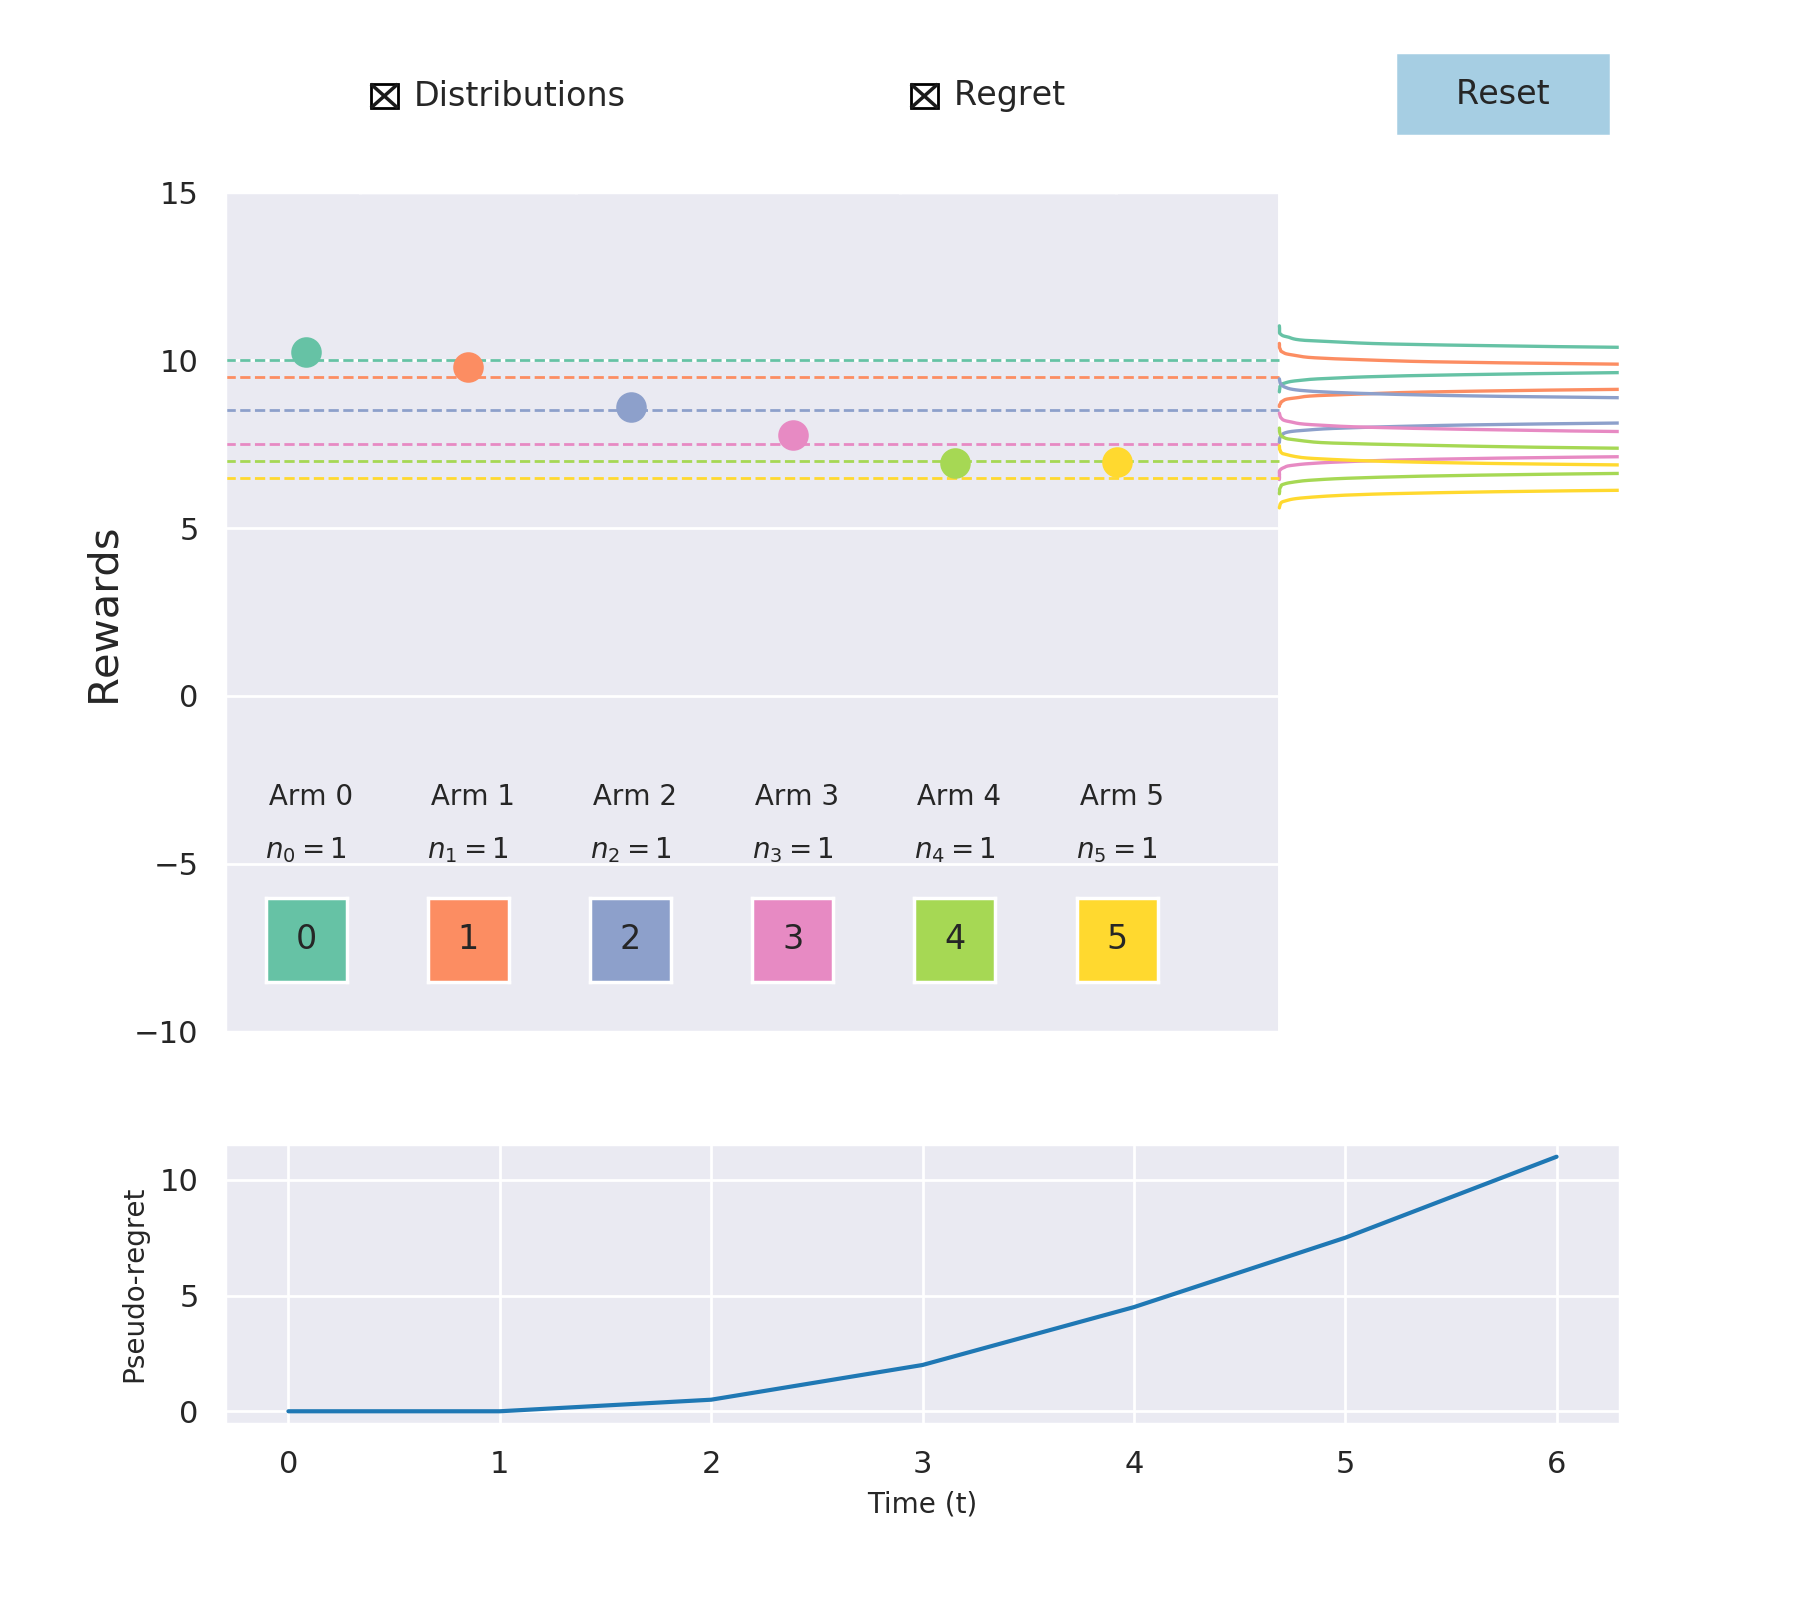

In [27]:
# Creates an interactive bandit instance.
#     - Pull an arm by clickling on the colored button
#     - The true means of the distributions are shown with the dashed horizontal lines
#     - Large solid circle is the sample mean of the arm
#     - Small empty circle is a sample from the arm
#     - The reward distribution of each arm is shown on the right and can be toggled on/off by checking the box
#     - Running Pseudo-regret is shown on the bottom and can be toggled on/off by checking the box

# You may need to rerun this cell to restart the gui.

%matplotlib notebook
plt.rcParams['figure.figsize']=[9,8]
bandit_env.run_Interactive()

# 1.  The Frequentist Approach: Upper Confidence Bounds (UCB)

The first algorithm we will analyze is the frequentist take on multi-armed bandits, known as the Upper Confidence Bounds (UCB) algorithm. 

For each arm $a \in \{ 0,1,...,K-1\}$, you keep track of:

1. $T_a(t)$: the number of times arm $a$ has been pulled up to and including iteration $t$.
2. $X_{a}^{(1)},...,X_{a}^{(T_a(t))}$: the samples you have received from arm $a$. Let $\hat \mu_{a,T_a(t)}$ be the mean of those samples: $\hat \mu_{a,T_a(t)} = \frac{1}{T_a(t)}\sum_{i=1}^{T_a(t)}X_{a}^{(i)}$

Using this information, you compute an upper confidence bound, $C_a(T_a(t),\delta)$ that encompasses the true mean $\mu_a$ with probability at least $1-\delta$, for some $\delta \in [0,1]$. $C_a(T_a(t),\delta)$, must therefore satisfy:

$$ \mathbb{P}\bigg(\mu_a < \hat \mu_{a,T_a(t)} + C_a(T_a(t),\delta)\bigg) > 1 - \delta.$$

As an edge case, after $0$ samples, we simply set the upper bound on $\mu_a$ to $\infty$, since it's always true that $\mathbb{P}(\mu_a < \infty) > 1 - \delta$.

The algorithm then pulls, at each round $t$, the arm with the highest upper confidence bound based on the results we saw up to time $t-1$:

$$ A_t=\underset{a \in \{ 0,1,...,K-1\}}{\operatorname{argmax}} \hat\mu_{a,T_a(t-1)} + C_a(T_a(t-1),\delta).$$

## A. The UCB algorithm
We will now implement the classic version of the UCB algorithm using the Hoeffding bound that we derived in Discussion 7 and Lecture 17. If you haven't watched the video for Discussion 7 yet, we highly recommend you do so to understand this next part.

Recall that for the sample mean of bounded random variables $X_{a}^{(1)},...,X_{a}^{(T_a(t))}$, $X_a^{(i)} \in [0,1]$, the Hoeffding bound says that for some $\epsilon \in [0,1]$,

$$ P( \hat \mu_{a,T_a(t)}-\mu_a \geq \epsilon) \leq e^{-2T_a(t)\epsilon^2}.$$

This bound results in the upper confidence bound on $\mu_a$:

$$P\left(\mu_a <\hat \mu_{a,T_a(t)} + \sqrt{\frac{\log{1/\delta}}{2T_a(t)}}\right)> 1-\delta. $$

where $\hat\mu_{a,T_a(t)}$ is the current sample mean for arm $a$:

$$ \hat\mu_{a,T_a(t)} =\frac{1}{T_a(t)} \sum_{i=1}^{T_a(t)} X_{a}^{(i)}$$

and the confidence bound term added to $\hat\mu_{a,T_a(t)}$ is:
$$C_a(T_a(t),\delta) = \sqrt{\frac{\log{1/\delta}}{2T_a(t)}}.$$

To handle the edge case where we've seen $0$ samples from arm $a$ so far (i.e. $T_a(t-1) = 0$), we set the upper bound on $\mu_a$ to $\infty$. Specifically, we set

$$ C_a(T_a(t-1),\delta) = \begin{cases} \infty \  &\text{ if } T_a(t-1)=0 \\  \sqrt{\frac{\log{1/\delta}}{2T_a(t-1)}} \ \ \ \ \ \  &\text{ if } T_a(t-1)>0\end{cases}$$
and 
$$ \hat\mu_{a,T_a(t-1)} = \begin{cases} \infty \  &\text{ if } T_a(t-1)=0 \\  \frac{1}{T_a(t-1)} \sum_{i=1}^{T_a(t-1)} X_{a}^{(i)} \ \ \ \ \ \  &\text{ if } T_a(t-1)>0\end{cases}$$

Finally, as mentioned earlier, we choose the arm $A_t$ at time $t$ as follows:

$$ A_t=\underset{a \in \{ 0,1,...,K-1\}}{\operatorname{argmax}} \hat\mu_{a,T_a(t-1)} + C_a(T_a(t-1),\delta).$$

We will choose a $\delta$ that decreases with time to ensure that we will explore the arms at first: 
$$ \delta=\frac{1}{t^3}$$

Now, use this formula for $ A_t$ to fill out the following function which returns the choice of arm as well as the upper confidence bounds of each arm. In the code below, we use the variable "confidence_bound" to refer to the entire term $\hat\mu_{a,T_a(t-1)} + C_a(T_a(t-1),\delta)$. 

In [36]:
# TODO: implement the algorithm for choosing the arm to pull, A_t.
def UCB_pull_arm(t, times_pulled, rewards):
    """ Implement the choice of arm for the UCB algorithm
    
    Args:
      t: the number of iterations of the bandit algorithm
      times_pulled: a list of length K (where K is the number of arms) of the number 
        of times each arm has been pulled.
      rewards: a list of K lists. Each of the K lists holds the samples received from
        pulling each arm up to iteration t. 
    
    Returns:
      arm: an integer representing the arm that the UCB algorithm would choose.
      confidence_bounds: a list of the confidence bounds for each arm
    """

    K = len(times_pulled)
    delta = 1/(t**3)
    
    confidence_bounds=[]
    for arm in range(K):
        if times_pulled[arm]==0:
            confidence_bounds.append(np.inf)
        else:
            # TODO: fill in the confidence bound for the given arm.
            # Hint: the \hat\mu_{a, T_a(t-1)} value is the mean of rewards[arm], 
            #   and the T_a(t-1) value is equal to times_pulled[arm].
            confidence_bounds.append(np.mean(rewards[arm]) + math.sqrt((math.log(1/delta)) / 2*times_pulled[arm])) 
            
    arm = np.argmax(confidence_bounds)
    
    return arm, confidence_bounds

Given the function you have filled out, let us investigate the pseudo-regret of the UCB algorithm.  Since the pseudo-regret is an expectation of the regret, the following cell runs the algorithm $20$ times and computes the average pseudo-regret across all runs.

<IPython.core.display.Javascript object>


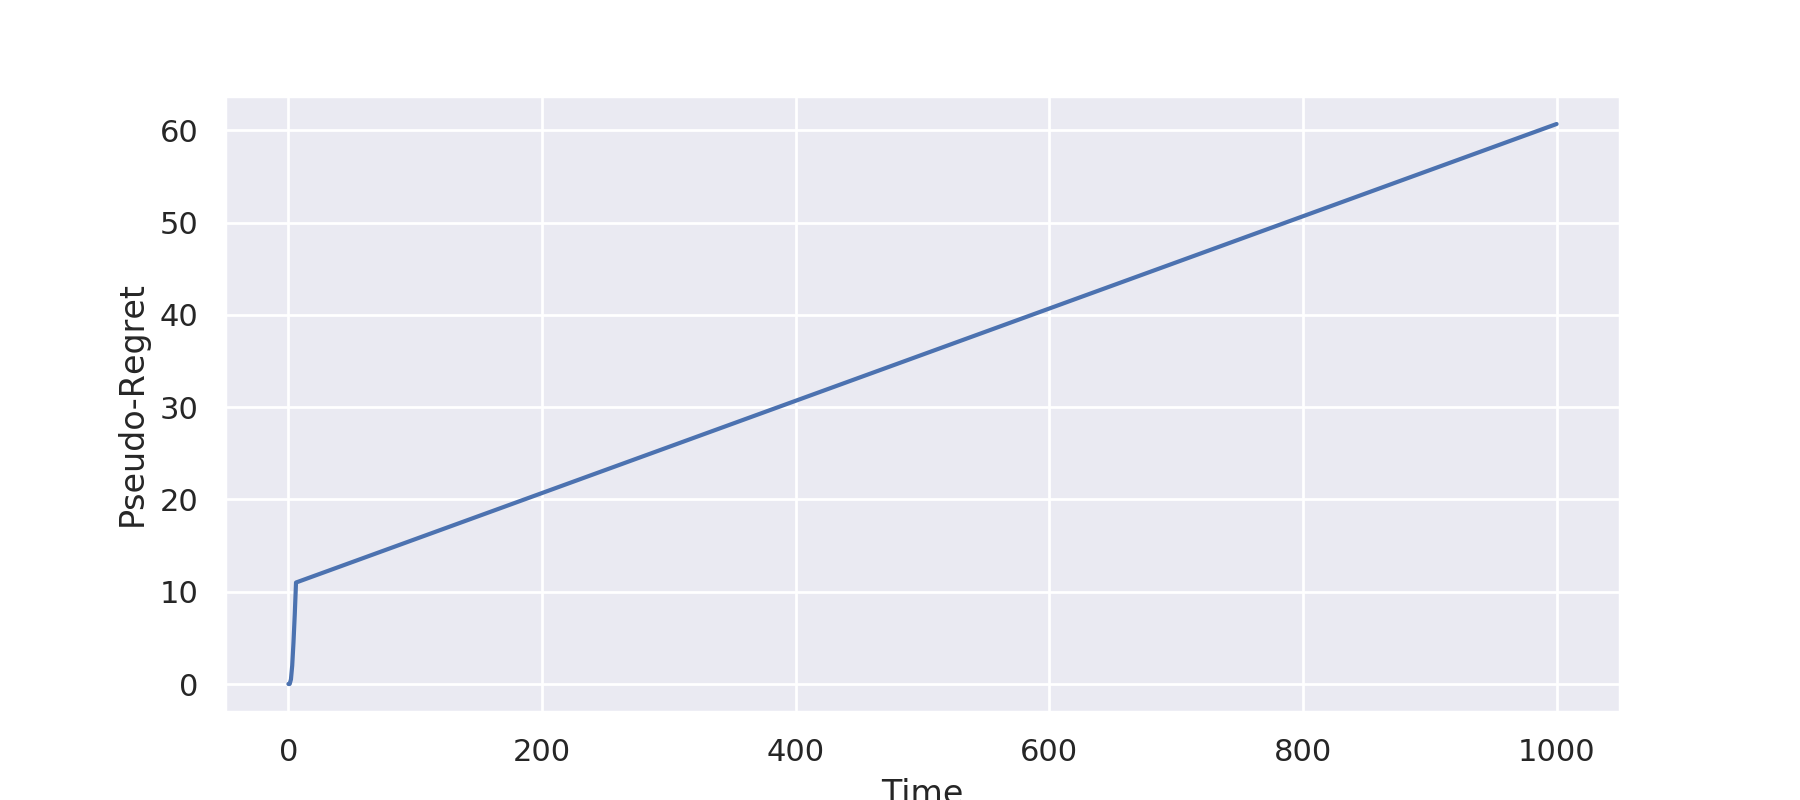

In [37]:
# No TODOs here, just run this cell to visualize the regret of your UCB algorithm.

#Initialize Figure
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

# Define the time horizon of each run, and the number of runs of each the algorithm.
T=1000
num_runs=20

#Initialize pseudo-regret
UCB_pseudo_regret=0
for runs in range(num_runs):
    #Initialize Bandit_environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Choose arm using UCB algorithm
        arm,confidence_bounds=UCB_pull_arm(t,bandit_env.times_pulled,bandit_env.rewards)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
        
    #Keep track of pseudo-regret  
    UCB_pseudo_regret+=np.array(bandit_env.regret)
    
#Make plot
plt.plot(UCB_pseudo_regret/num_runs)
plt.xlabel('Time')
plt.ylabel('Pseudo-Regret')
plt.show()

### Visualize Your Algorithm
If you want to visualize your algorithm, you can use the following interactive demo (If it is lagging, do not worry this part is not graded and is meant to build your intuition for the algorithm):

<IPython.core.display.Javascript object>


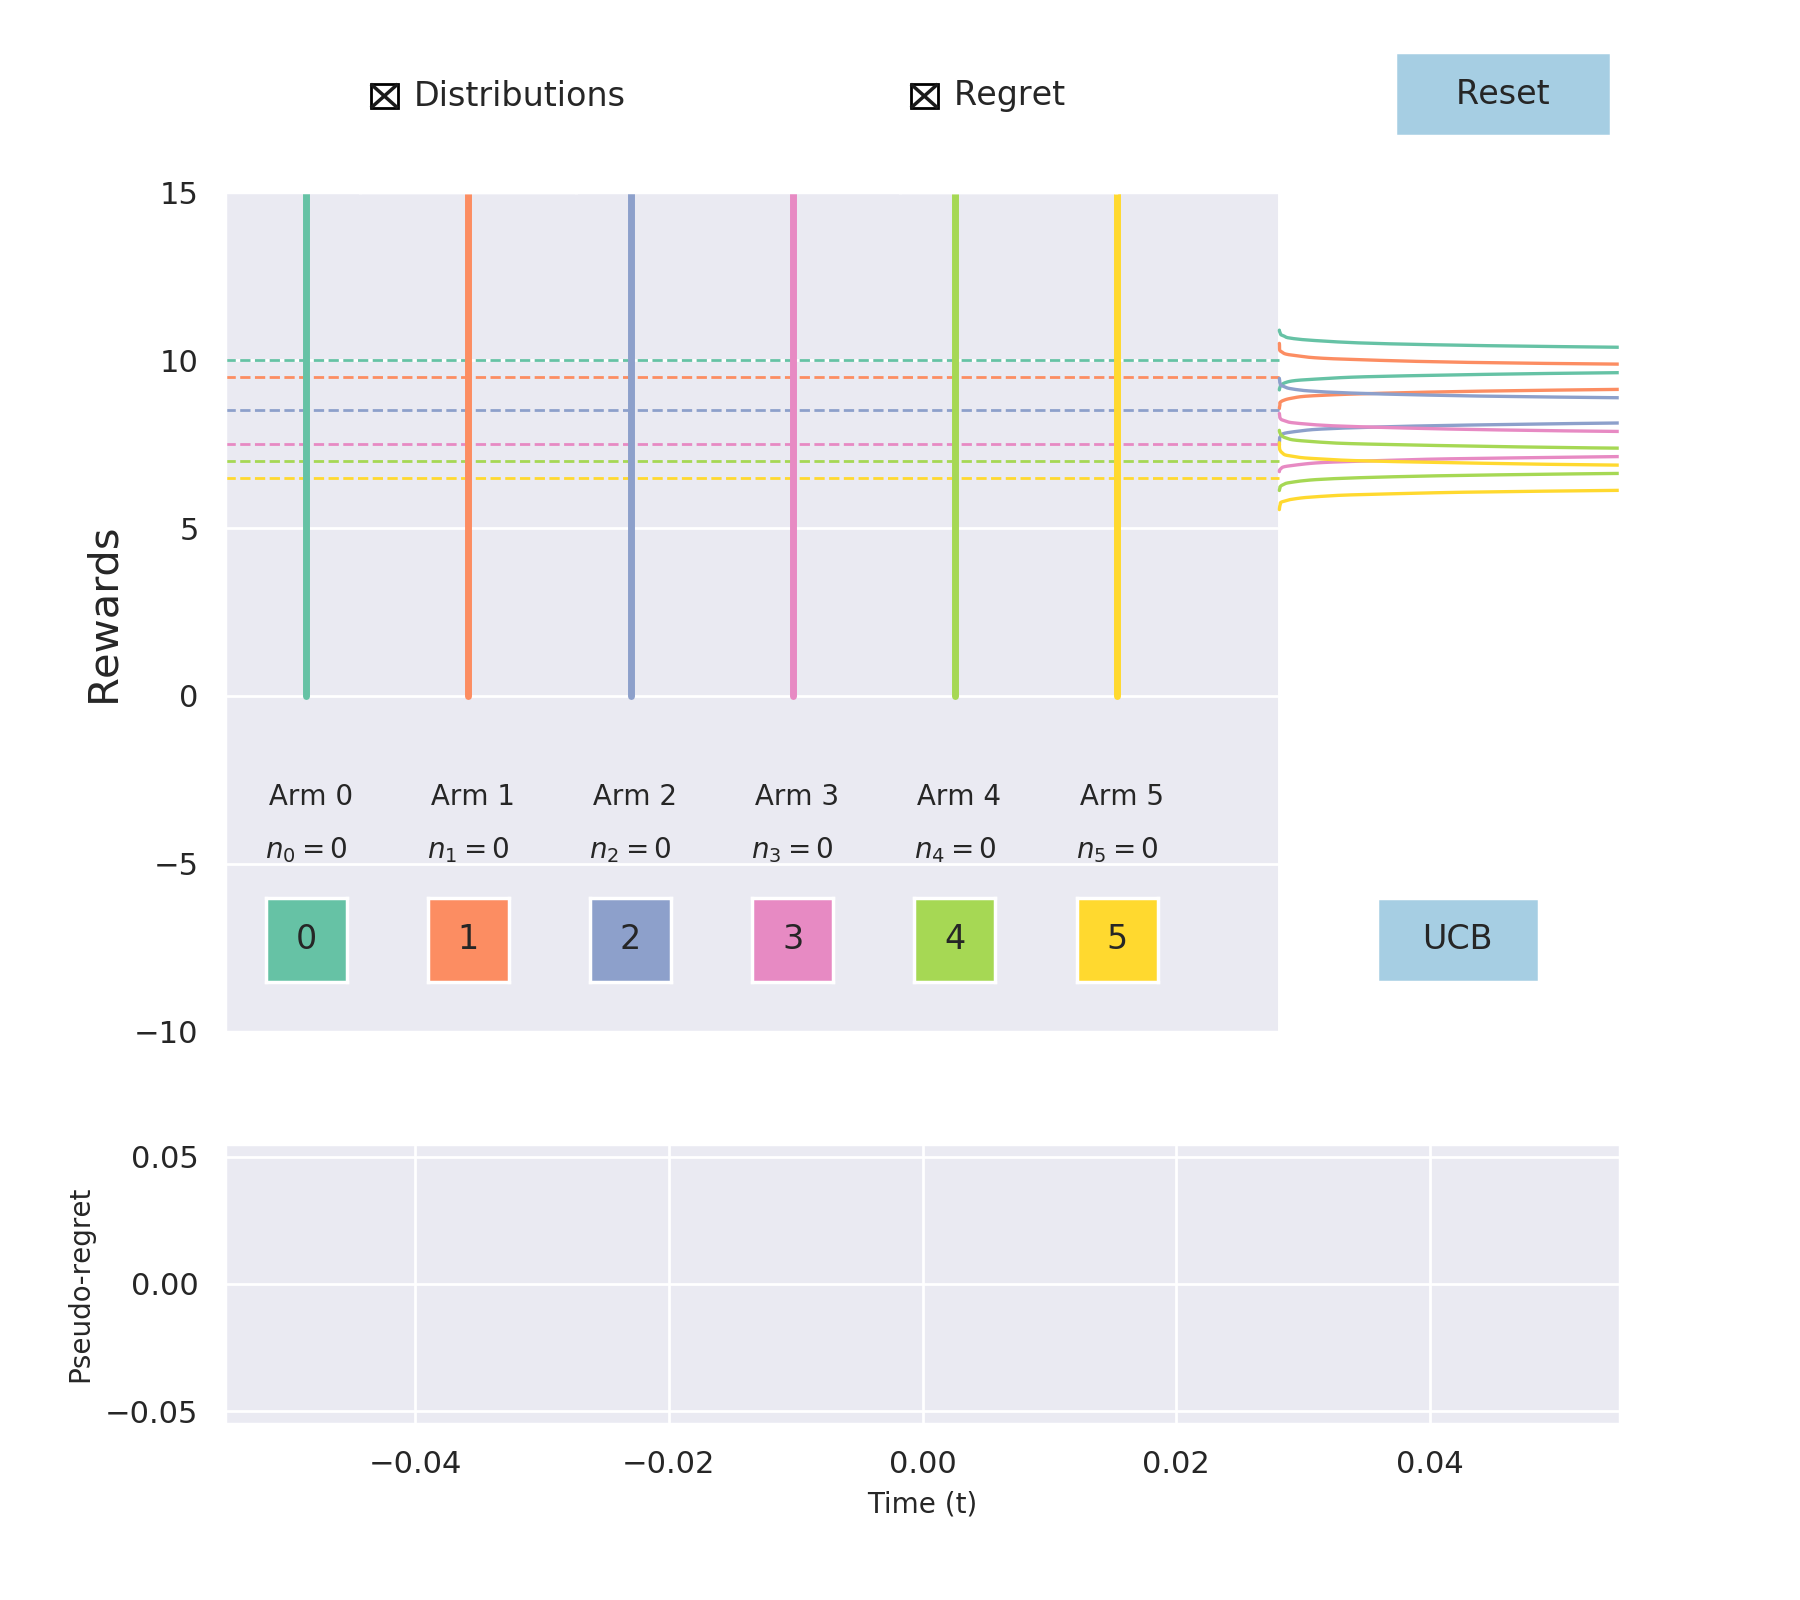

In [30]:
# No code TODOs here, just run this cell and click the "UCB" button in the lower right to visualize which
# arm gets picked at each timestep t.

plt.rcParams['figure.figsize']=[9,8]

# Creates an interactive bandit instance with an option to test your algorithm.
#     - Pull an arm by clickling on the colored button
#     - Allow your algorithm to choose the arm by clicking on the "UCB" button in the lower right.
#     - The true means of the distributions are shown with the dashed horizontal lines
#     - Large solid circle is the sample mean of the arm
#     - Solid vertical line is the upper confidence bound you have calculated
#     - The reward distribution of each arm is shown on the right and can be toggled on/off by checking the box
#     - Running Pseudo-regret is shown on the bottom and can be toggled on/off by checking the box

# You may need to rerun this cell to restart the gui
alg=Interactive_UCB_Algorithm(bandit_env,UCB_pull_arm,'UCB')
alg.run_Interactive_Alg()

# 2. The Bayesian Approach: Thompson Sampling
The second algorithm we will analyze is the Bayesian take on multi-armed bandits, known as Thompson Sampling. In this setting, you begin with a prior over the mean of each arm $\pi_a(\mu_a)$.

At each round $t=1,2...$, the algorithm computes the posterior probability $p_{a,t}$ that arm $a\in \mathcal{A}$ has the highest mean reward:

$$ p_{a,t}=\mathbb{P}\bigg(\mu_a=\max_{a'} \mu_{a'} \ \bigg| \ X_{A_1}^{(1)},...,X_{A_{t-1}}^{(t-1)}\bigg).$$

The choice of arm is then randomly sampled from the distribution $p_t$ over $\mathcal{A}$, where each arm $a\in \mathcal{A}$ has probsbility $p_{a,t}$:

$$ A_t \sim p_t $$ 

## Implementing Thompson Sampling

Since the posterior distribution over each arm having the maximum mean is often intractable to compute, in practice we often implement a simpler algorithm that nevertheless accomplishes the same task.

At each rount $t=1,2....$, you keep track of the posterior distribution over $\mu_a$, for each arm $a \in \{ 0,1,...,K-1\}$,  given all the samples you have observed from that arm $X_{a}^{(1)},...,X_{a}^{(T_a(t-1))}$:

$$P_{a,t}=\mathbb{P}(\mu_a | X_{a}^{(1)},...,X_{a}^{(T_a(t-1))}).$$

You then take one sample from $P_{a,t}$ and choose the arm with the highest sample:

1. $\mu_{a,t} \sim  P_{a,t}$ for $a \in \{0,1,...,K-1\}$.
2. Choose arm:
$$ A_t=\underset{a \in \{ 0,1,...,K-1\}}{\operatorname{argmax}} \mu_{a,t}$$

Since the reward distributions in this lab are Gaussians with known variance $\sigma_a^2$, we know from our investigation of conjugate priors that if we have Gaussian priors: $\pi_a(\mu_a)=\mathcal{N}(\mu_{a,0},\sigma_{a,0}^2)$, the posterior distribution for each arm will also be a Gaussian. 

Therefore, to implement Thompson Sampling in this lab, the posterior distributions for each arm in this lab at each time $t=1,2,...$ are given by:

$$ P_{a,t}=\mathcal{N}(\hat\mu_{a,t},\hat{\sigma}_{a,t}^2)$$

where,
 $$\hat{\sigma}_{a,t}^2 =\bigg(\frac{1}{\sigma_{a,0}^2}+\frac{T_a(t-1)}{\sigma_a^2}\bigg)^{-1} $$
$$ \hat\mu_{a,t}=\hat{\sigma}_{a,t}^2 \bigg( \frac{\mu_{a,0}}{\sigma_{a,0}^2}+\frac{\sum_{i=1}^{T_a(t-1)} X_{a}^{(i)}}{\sigma_a^2} \bigg)$$

Fill out the following function that implements the choice of arm for the Thompson Sampling algorithm with Gaussian arms and prior. 

In [31]:
# TODO: implement the algorithm for choosing the arm to pull, A_t.
def TS_pull_arm(t, variance, times_pulled, rewards, prior_means, prior_variances):
    """ 
    Implement the choice of arm for the Thompson Sampling Algorithm when the arms and priors are Gaussians.
    
    Args:
      t: number of iteration of the bandit algorithm.
      variance: the known variance of each arm (all arms have the same variance).
      times_pulled: a list of length K (where K is the number of arms) of the number of 
        times each arm has been pulled.
      rewards: a list of K lists. Each of the K lists holds the samples received from pulling each arm up 
        to iteration t.
      prior_means: a list of length K with the mean of the priorsfor each arm.
      prior_variances: a list of length K with the variance of the prior for each arm.
    
    Returns:
      arm: integer representing the arm that the UCB algorithm would choose.
      posterior_samples: list of samples from the posterior used to choose the arm. 
      posterior_means: list of means of the posterior for each arm
      posterior_vars: list of variances of the posteriors of each arm
    """

    K = len(times_pulled)
    
    posterior_samples = []
    posterior_means = []
    posterior_vars = []
    for arm in range(K):
        # TODO: fill in arm_var, which is \hat\sigma^2_{a,t}.
        # Hint: \hat\sigma^2_{a,0} is prior_variances[arm], \sigma^2_a is variance,
        #   and T_a(t-1) is times_pulled[arm] (as before).
        arm_var = ((1 / prior_variances[arm]) + (times_pulled[arm] / variance)) ** -1 #todo
        # TODO: fill in mean, which is \hat\mu_{a,t}.
        # Hint: \mu_{a,0} is prior_means[arm], and X_a^{(i)} is rewards[arm] (as before).
        mean = arm_var * ((prior_means[arm] / prior_variances[arm]) + (sum(rewards[arm]) / variance)) #todo
        
        posterior_samples.append(np.random.normal(mean,arm_var,1))
        posterior_means.append(mean)
        posterior_vars.append(arm_var)
            
    arm = np.argmax(posterior_samples)
    
    return arm , posterior_samples , posterior_means,posterior_vars

## A. Thompson Sampling with Good Priors
As we saw in class, the performance of Thompson Sampling can vary drastically with the quality of the prior. 

First, let us analyze the performance of Thompson Sampling when the priors reflect the correct rankings of the arms (meaning that the prior mean for arm $0$ is the highest). We will compare it to the performance of the UCB algorithm.

<IPython.core.display.Javascript object>


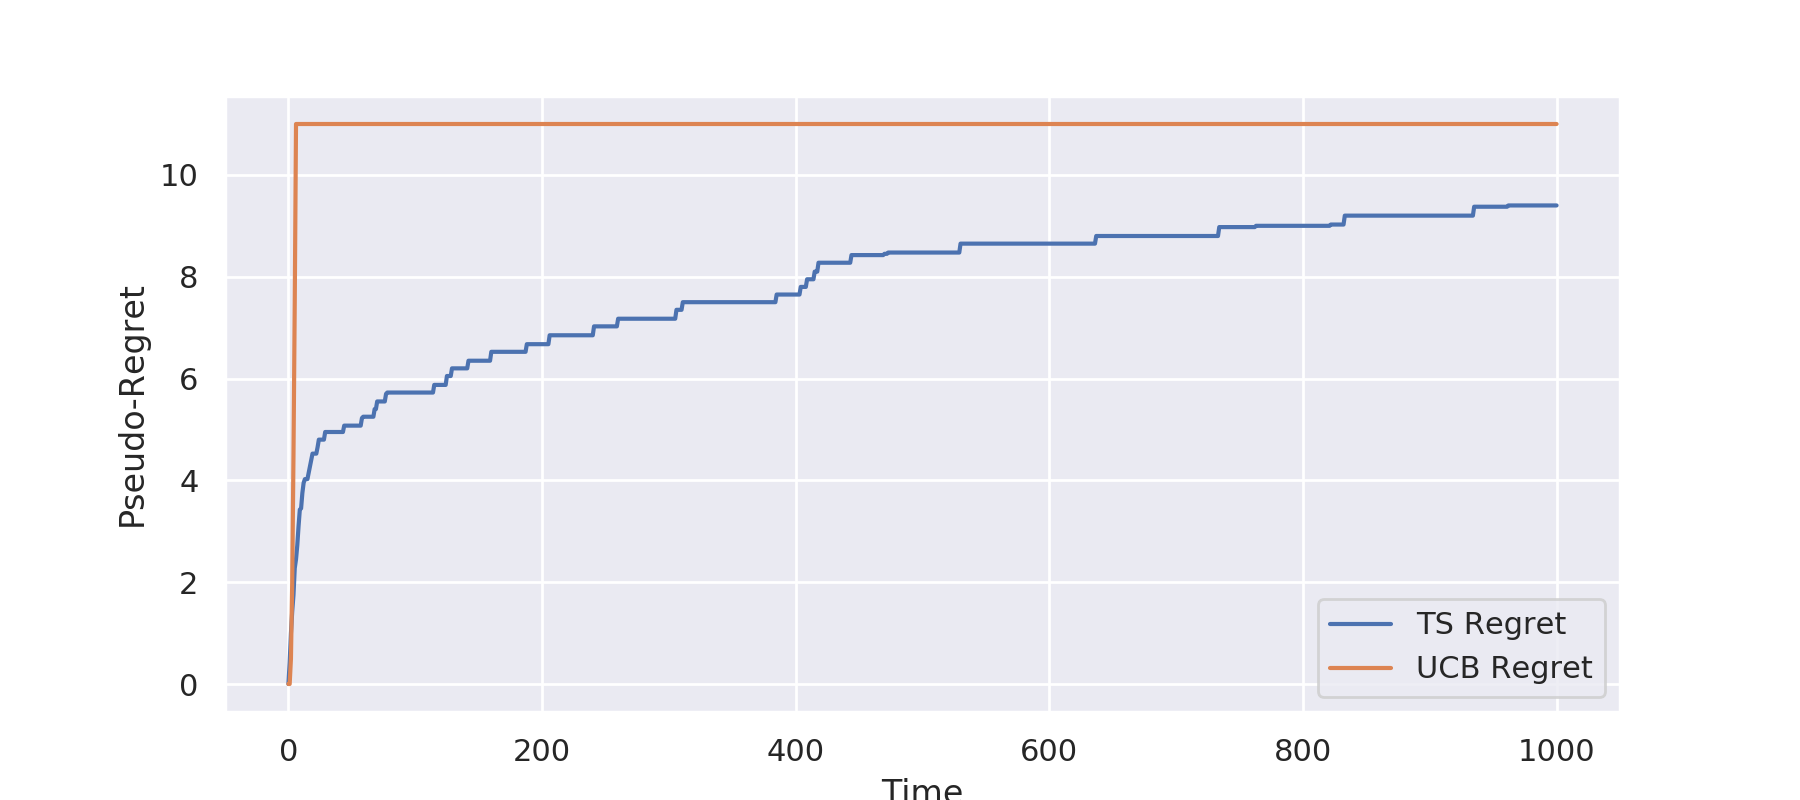

In [32]:
# No TODOs here, just run this cell to visualize the regret of your Thompson Sampling algorithm.
# This cell will also plot the regret of the UCB algorithm as a comparison.

#Initialize Figure
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

#Define Prior Means and Variances
prior_means=[12,9,8,7,4,3]
prior_vars=[2.2,2.2,2.2,2.2,2.2,2.2]

#Initialize pseudo-regret
TS_pseudo_regret=0
for runs in range(num_runs):
    #Initialize bandit environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Choose arm with Thompson Sampling
        arm,samples,means,variances=TS_pull_arm(t,variance,bandit_env.times_pulled,bandit_env.rewards,prior_means,prior_vars)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
    
    #Keep track of regret Regret
    TS_pseudo_regret+=np.array(bandit_env.regret)
    
#Plot Thompson Sampling vs. UCB regret
plt.plot(TS_pseudo_regret/num_runs ,label='TS Regret')
plt.plot(UCB_pseudo_regret/num_runs ,label='UCB Regret')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pseudo-Regret')
plt.show()

## B. Thompson Sampling with Bad Priors
Now let us analyze the performance of Thompson Sampling when the priors have completely incorrect correct rankings of the arms, meaning that the prior mean for arm $0$ is the lowest.

<IPython.core.display.Javascript object>


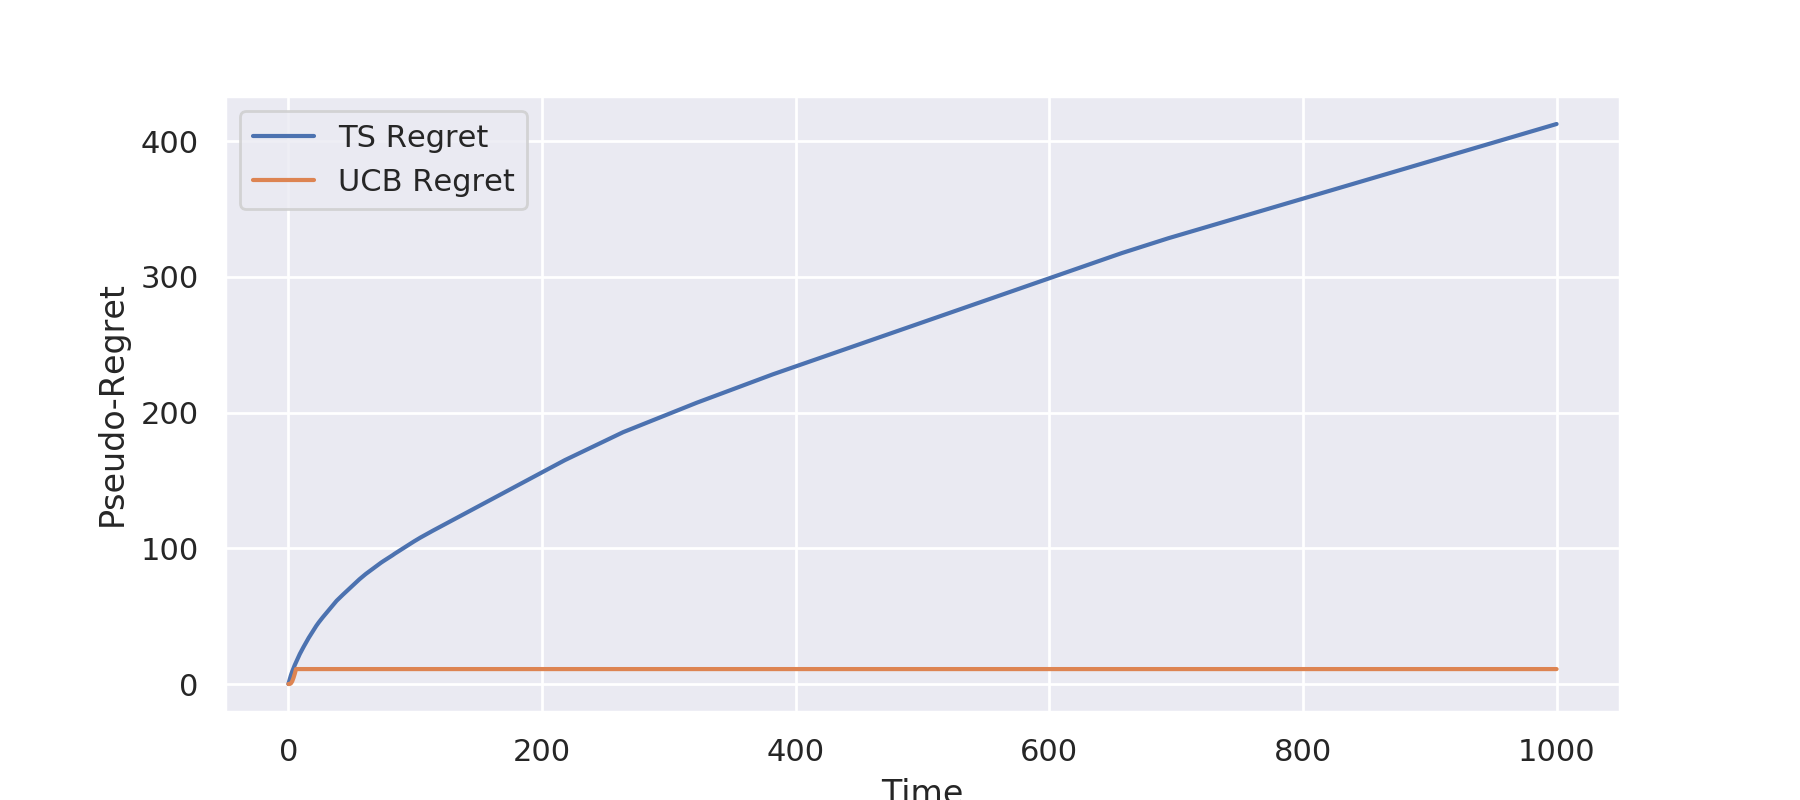

In [33]:
# No TODOs here, just run this cell to visualize the regret of your Thompson Sampling algorithm.
# This cell will also plot the regret of the UCB algorithm as a comparison.

#Initialize Figure
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

#Define prior means and standard deviations
prior_means=[2,3,4,5,6,7]
prior_vars=[2.2,2.2,2.2,2.2,2.2,2.2]

#Initialize pseudo-regret
TS_pseudo_regret=0
for runs in range(num_runs):
    #Initialize bandit environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Chosoe arm with Thompson Sampling
        arm,samples,means,variances=TS_pull_arm(t,variance,bandit_env.times_pulled,bandit_env.rewards,prior_means,prior_vars)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
    
    #Keep track of regret Regret
    TS_pseudo_regret+=np.array(bandit_env.regret)
    
#Plot Thompson Sampling vs. UCB regret
plt.plot(TS_pseudo_regret/num_runs ,label='TS Regret')
plt.plot(UCB_pseudo_regret/num_runs ,label='UCB Regret')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pseudo-Regret')
plt.show()

## B. Thompson Sampling with the same prior for each arm
Now let us analyze the performance of Thompson Sampling when the priors are the same for all arms.

<IPython.core.display.Javascript object>


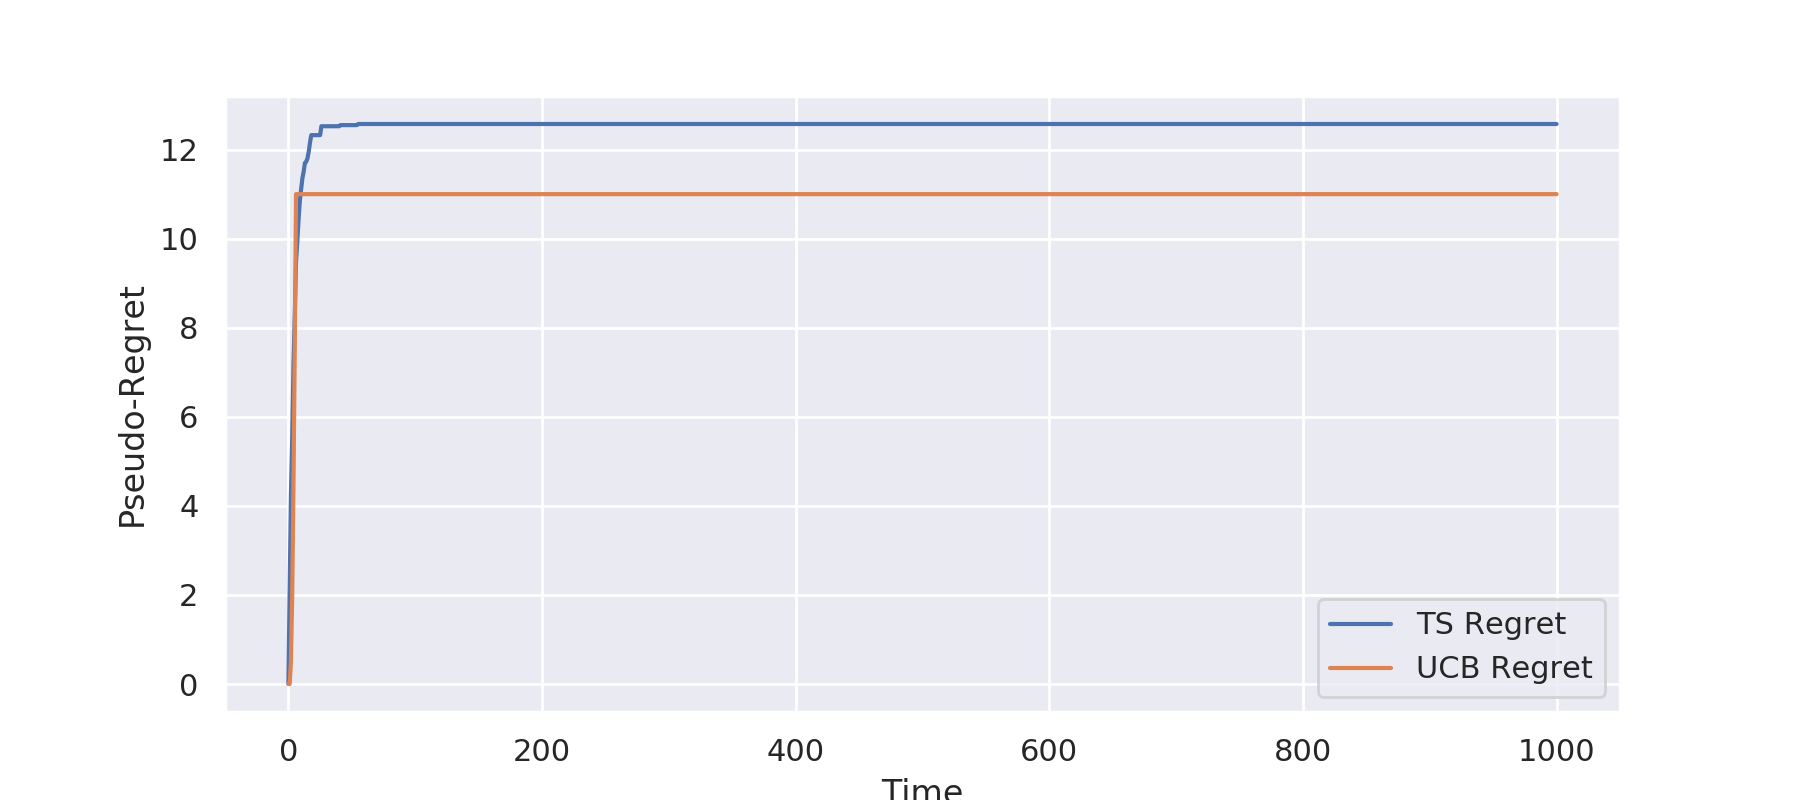

In [34]:
# No TODOs here, just run this cell to visualize the regret of your Thompson Sampling algorithm.
# This cell will also plot the regret of the UCB algorithm as a comparison.

#Make Figure
plt.rcParams['figure.figsize'] = [9,4]
plt.figure()

#Define prior means and variances
prior_means = [8,8,8,8,8,8]
prior_vars = [2.5,2.5,2.5,2.5,2.5,2.5]

#Initialize pseudo-regret
TS_pseudo_regret=0
for runs in range(num_runs):
    #Initialize bandit environment
    bandit_env.initialize(make_plot=0)
    for t in range(1, T+1):
        #Chosoe arm with Thompson Sampling
        arm,samples,means,variances = TS_pull_arm(t,variance,bandit_env.times_pulled,bandit_env.rewards,prior_means,prior_vars)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
    
    #Keep track of regret Regret
    TS_pseudo_regret += np.array(bandit_env.regret)
    
#Plot Thompson Sampling vs. UCB regret
plt.plot(TS_pseudo_regret/num_runs , label='TS Regret')
plt.plot(UCB_pseudo_regret/num_runs , label='UCB Regret')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pseudo-Regret')
plt.show()

### Visualize Your Algorithm
If you want to visualize your algorithm, you can use the following interactive demo (If it is lagging, do not worry this part is not graded and is meant to build your intuition for the algorithm):

<IPython.core.display.Javascript object>


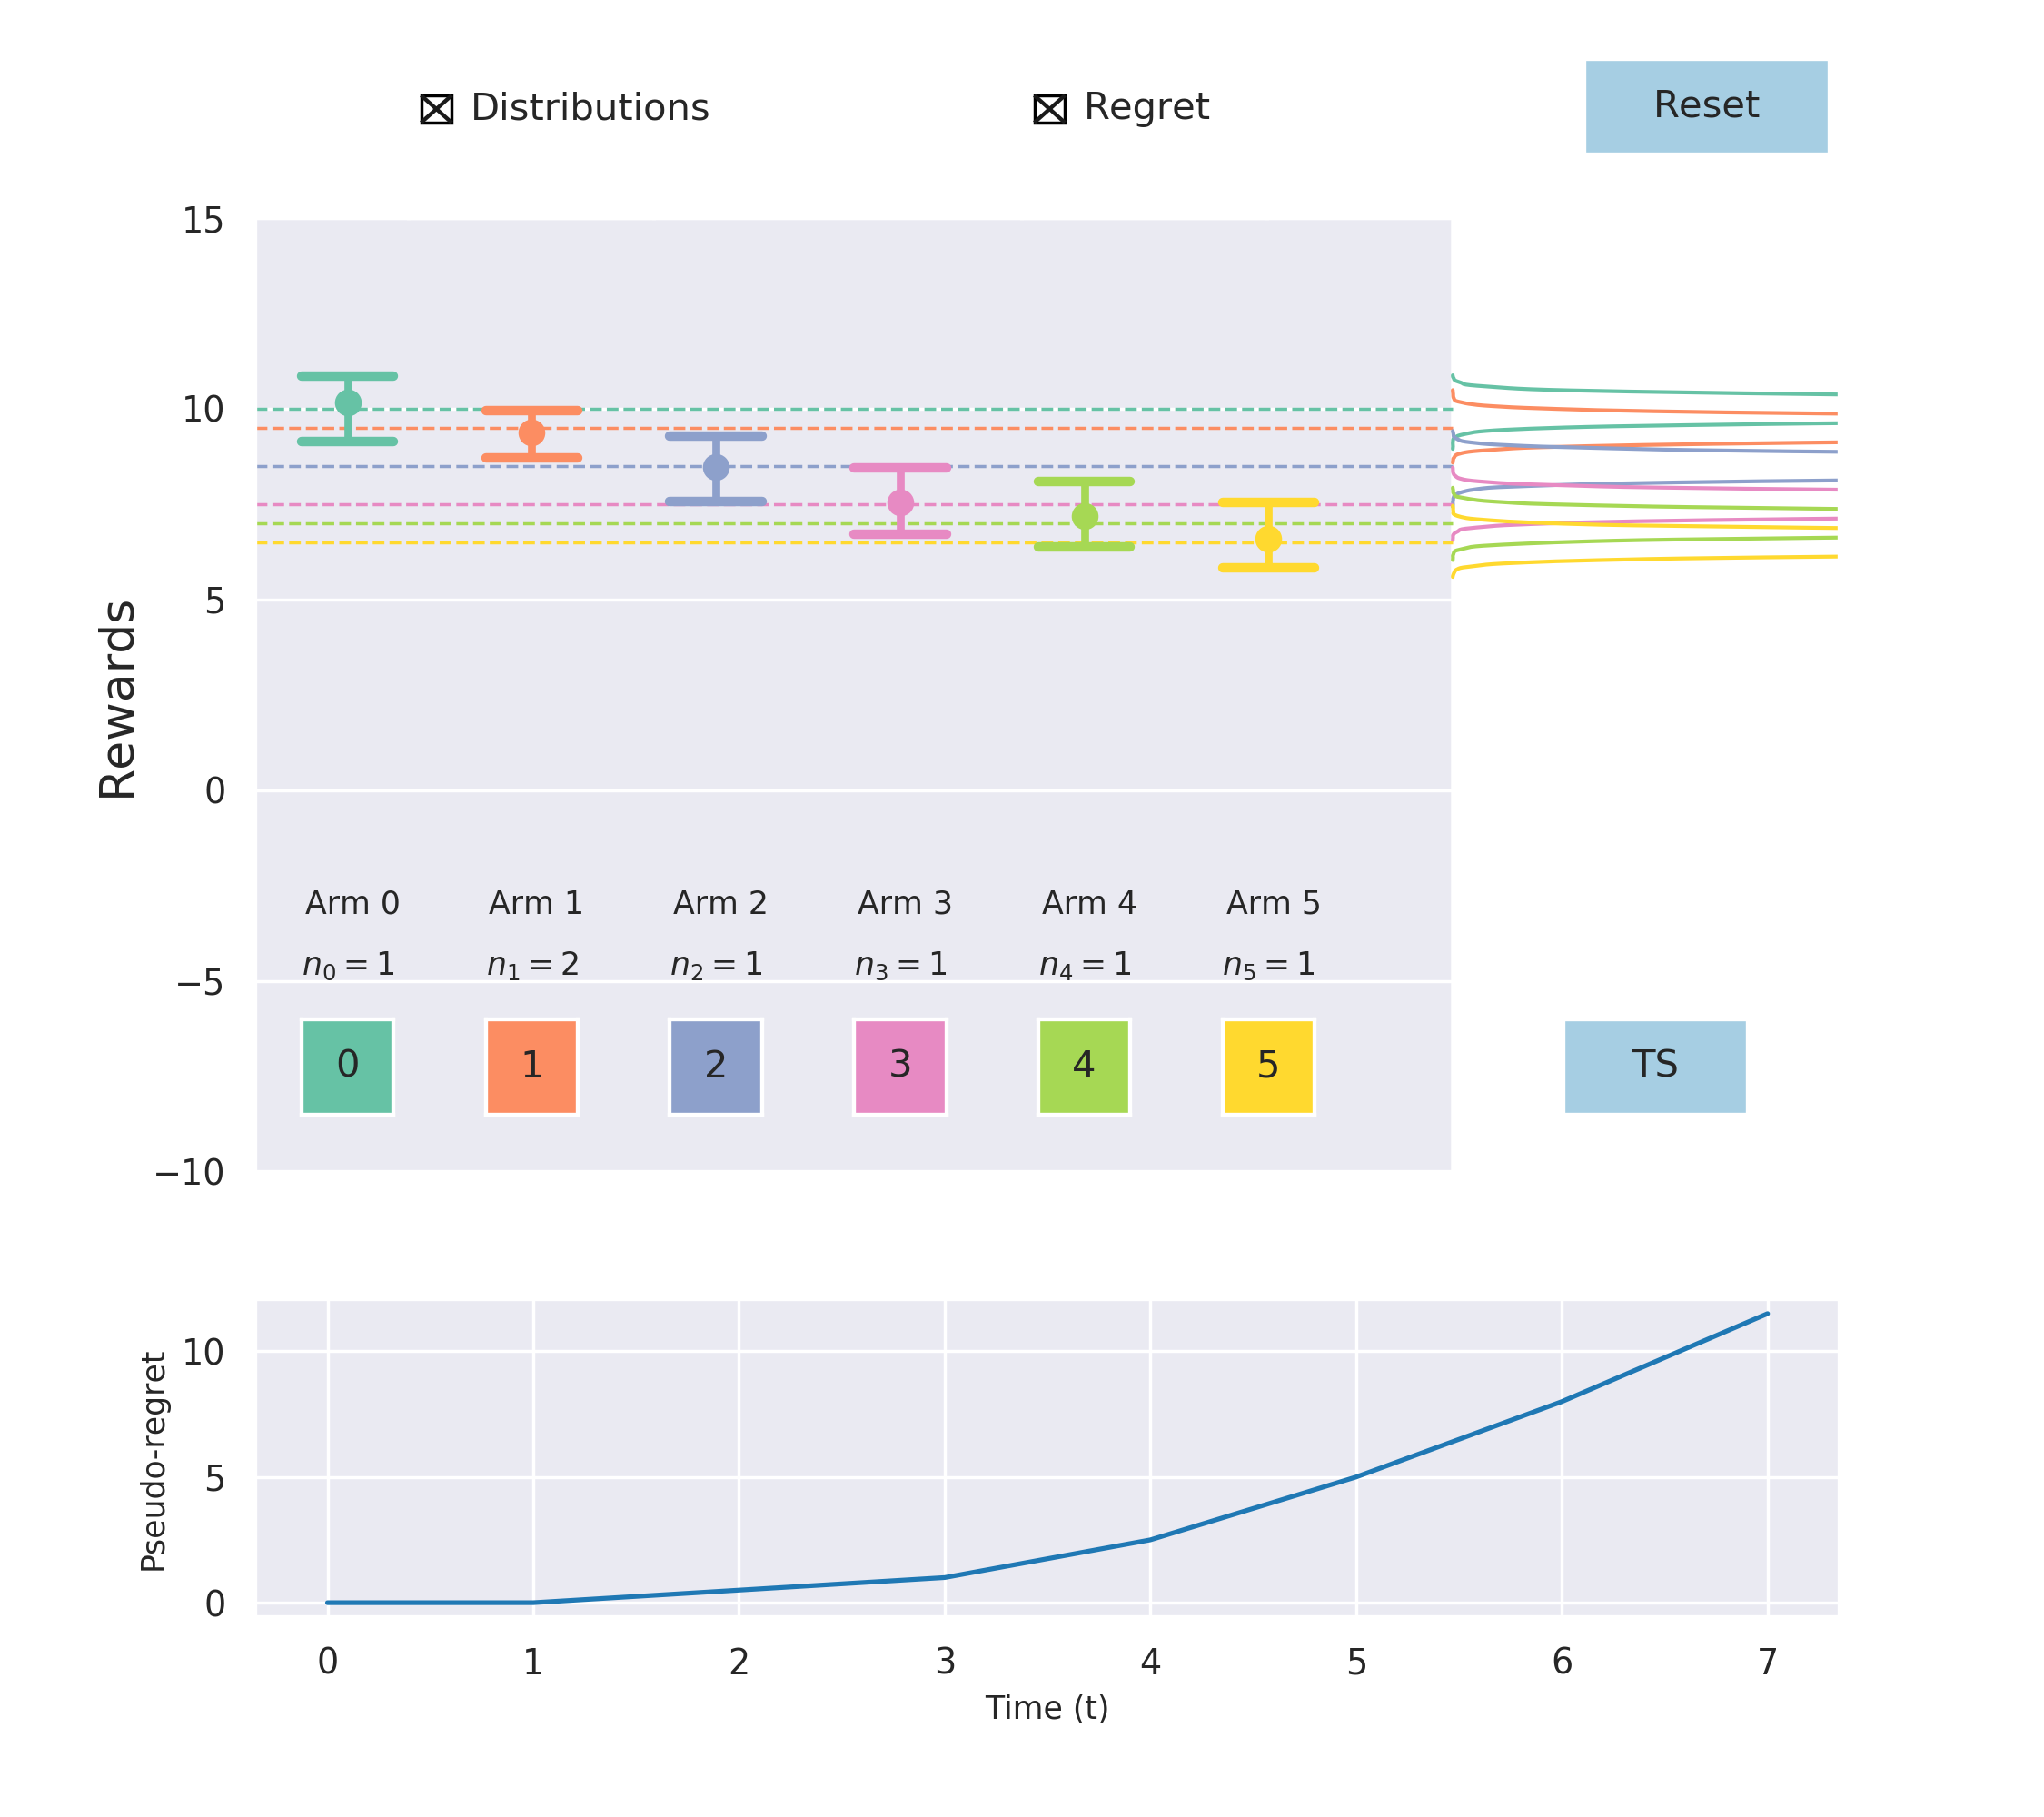

In [38]:
# No code TODOs here, just run this cell and click the "TS" button in the lower right to visualize which
# arm gets picked at each timestep t.

plt.rcParams['figure.figsize']=[9,8]

# Creates an interactive bandit instance with an option to test your algorithm.
#     - Pull an arm by clickling on the colored button.
#     - Allow your algorithm to choose the arm by clicking on the "TS" button in the lower right.
#     - The true means of the distributions are shown with the dashed horizontal lines.
#     - Large solid circle is the sample mean of the rewards for the arm.
#     - Solid vertical line shows the 95% credible interval for the arm.
#     - The reward distribution of each arm is shown on the right and can be toggled on/off by checking the box.
#     - Running Pseudo-regret is shown on the bottom and can be toggled on/off by checking the box.

# You may need to rerun this cell to restart the gui
alg=Interactive_TS_Algorithm(bandit_env,TS_pull_arm,'TS',prior_means,prior_vars)
alg.run_Interactive_Alg()

## 3. Pros and Cons of UCB and Thompson Sampling

In the following cell, write a few sentences comparing and contrasting UCB and Thompson Sampling. What are some pros and cons of UCB and of Thompson Sampling?

UCB creates confidence interval over the sample (Frequentist) by using Hoeffding inequality. Thompson Sampling utilizes prios (Bayesian). UThompson Sampling's performance varies drastically based on the goodness of the prior. Good priors will outperform UCB however bad priors will do worse. The pro of UCB is it will always pull the best arm. Con is it may be slow. Thompson can be either very good or bad so that is both the pro and con.